# Table of Contents
* [Description](#Description)
* [Import Python](#Import-Python)
* [Import Data to Correct](#Import-Data-to-Correct)
* [Cylindrical Geometry Correction](#Cylindrical-Geometry-Correction)
	* [Rotate all Images](#Rotate-all-Images)
	* [Select Cylinder Dimensions and Position](#Select-Cylinder-Dimensions-and-Position)
	* [Recap Data Characteristics](#Recap-Data-Characteristics)
	* [Truncate Data to keep only object](#Truncate-Data-to-keep-only-object)
	* [Loop over all slices of all images to correct geometry](#Loop-over-all-slices-of-all-images-to-correct-geometry)


# Description

# Import Python

In [72]:
import custom_style
custom_style.style()

In [103]:
verbose = False
debugging = False
ipts_group = 'IPTS_17099'

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

import config_handler
import file_handler
import utilities
import gui_widgets
import time_utility
import geometry_correction

display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: we are importing all \
        the python libraries</span>\
        <br><br><span style="font-size: 20px; color:blue"><b>Make sure you wait until a cell\
        is done executing before running another cell!</span>'))

In [74]:
%gui qt

# Import Data to Correct

In [75]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: select the folder that contains \
the data you want to normalize!</span>'))
            
data_folder = config_handler.load_config(key='data_folder',
                                        default_value = '/HFIR/CG1D/{}'.format(ipts_group),
                                        group=ipts_group)
new_data_folder = gui_widgets.gui_dname(dir=data_folder,
                                   message='Select the Data Folder ...')
if new_data_folder:
    config_handler.save_config(key='data_folder', value=new_data_folder, group=ipts_group)
    list_of_data_files = glob.glob(new_data_folder + '/*.tiff')

In [76]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: the program is now loading all the data...\
Please Be Patient!</span>'))

w = widgets.IntProgress()
w.max = len(list_of_data_files)
display(w)

data_array = []
for _index, _file in enumerate(list_of_data_files):
    _image = file_handler.load_data(_file)
    data_array.append(_image)
    w.value = _index + 1
    
[height, width] = np.shape(data_array[0])
    
print("we loaded {} files".format(len(list_of_data_files)))
print("Images are {} pixels height by {} pixels wide".format(height, width))

we loaded 741 files
Images are 400 pixels height by 200 pixels wide


In [77]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: in the next cell, you visualize the data. \
Play with the slider to browse through the images.</span>'))

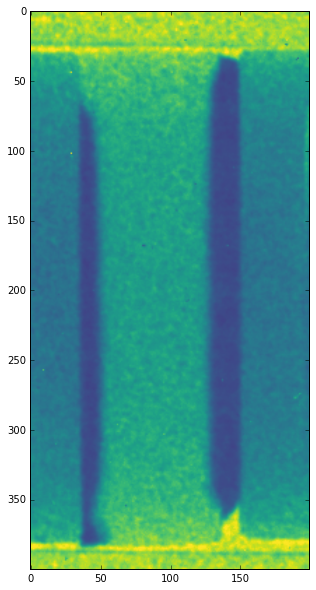

In [78]:
def plot_images(image_index, image_size):
    
    fig = plt.figure(figsize=(image_size, image_size))
    ax_img = plt.subplot(111)
    ax_img.imshow(data_array[image_index], cmap='viridis', vmin=0, vmax=1)

preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0, 
                                                max=len(data_array)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index'),
                  image_size = widgets.IntSlider(min=5,
                                                max=20,
                                                value=10))

# Cylindrical Geometry Correction

## Rotate all Images

The cylindrical geometry correction works on data set that have cylinders oriented vertically. We need to rotate all the images to be able to apply the geometry correction

In [79]:
# rotate images
rotated_data_array = []
for _data in data_array:
    rot_data = np.rot90(_data)
    rotated_data_array.append(rot_data)

[rot_height, rot_width] = np.shape(rotated_data_array[0])

## Select Cylinder Dimensions and Position 

{'left_edge': 28, 'right_edge': 378}

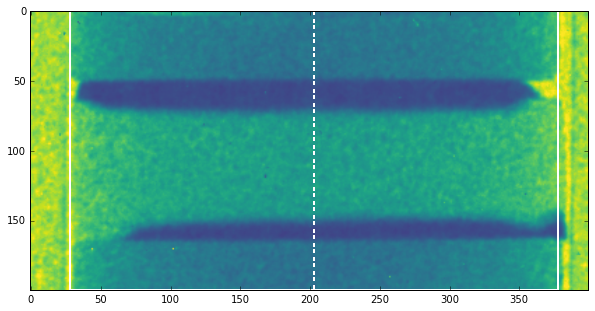

In [95]:
def plot_images(image_index, image_size, left_edge, right_edge):
    
    fig = plt.figure(figsize=(image_size, image_size))
    ax_img = plt.subplot(111)
    ax_img.imshow(rotated_data_array[image_index], cmap='viridis', vmin=0, vmax=1)

    _rectangle = patches.Rectangle((left_edge, 0),
                                  right_edge - left_edge,
                                  rot_height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    _center_line = patches.Rectangle(((right_edge+left_edge)/2, 0),
                                     0,
                                     rot_height,
                                     edgecolor='white',
                                     linewidth = 2,
                                     linestyle = 'dashdot',
                                     fill = False)
    ax_img.add_patch(_center_line)
    
    return {'left_edge': left_edge, 
            'right_edge': right_edge}
    
edge_selection = interact(plot_images,
                      image_index = widgets.IntSlider(min=0, 
                                                    max=len(data_array)-1,
                                                    step=1,
                                                    value=0,
                                                    description='Image Index'),
                      image_size = widgets.IntSlider(min=5,
                                                    max=20,
                                                    value=10),
                         left_edge = widgets.IntSlider(min=0,
                                                      max=rot_width-1,
                                                      value=28,
                                                      description='Left Edge'),
                         right_edge = widgets.IntSlider(min=0,
                                                       max=rot_width-1,
                                                       value=378,
                                                       description='Right Edge'))

## Recap Data Characteristics

In [125]:
[nbr_files, height, width] = np.shape(rotated_data_array)
left_edge = edge_selection.widget.result['left_edge']
right_edge = edge_selection.widget.result['right_edge']
if not(np.int((left_edge + right_edge)/2) == (left_edge + right_edge)/2):
    right_edge += 1
    
# pixel_center 
pixel_center = np.int((right_edge + left_edge)/2)
print("pixel center: {}".format(pixel_center))

# radius
radius = np.int((right_edge - left_edge)/2)
print("radius: {}".format(radius))

pixel center: 203
radius: 175


## Truncate Data to keep only object

In [126]:
truncated_image = []
for _image in rotated_data_array:
    _trunc_image = _image[:, pixel_center-radius : pixel_center+radius+1]
    truncated_image.append(_trunc_image)
    
[nbr_images, height, new_width] = np.shape(truncated_image)

## Loop over all slices of all images to correct geometry

/Users/j35/git/IPTS/IPTS_17099/geometry_correction.py:10: RuntimeWarning:

divide by zero encountered in double_scalars



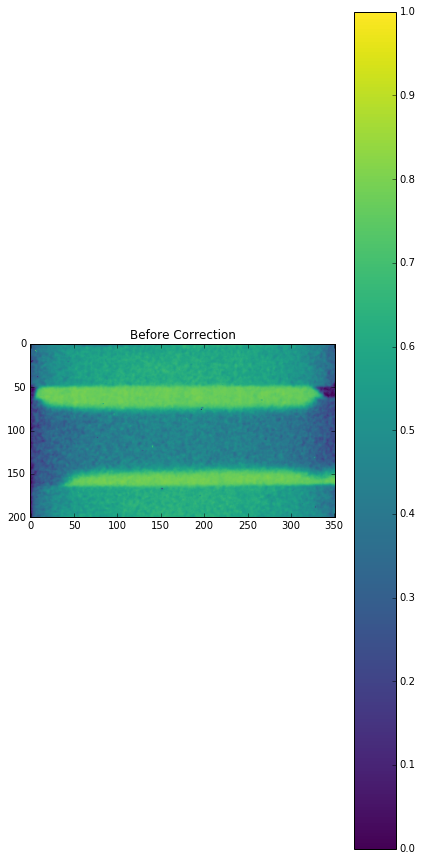

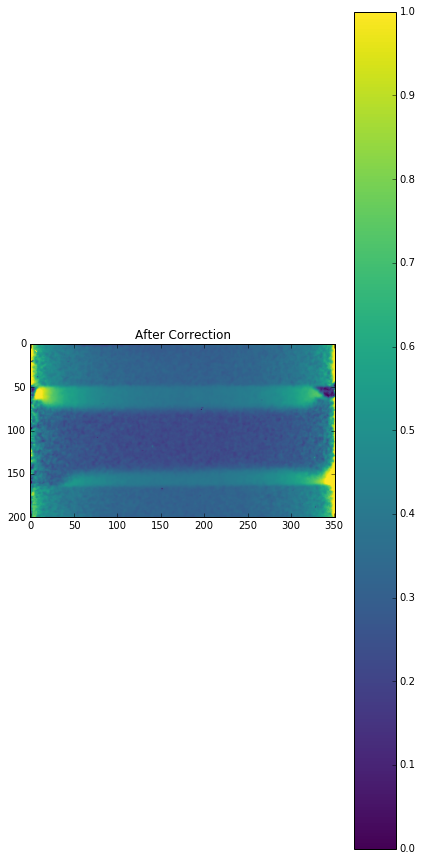

In [127]:
# test only on 1 image
_image = 1- truncated_image[100]
corrected_image = np.zeros([height, new_width])
for _h in np.arange(height):
    _expected_slice = []
    _slice = _image[_h, :]
    for _index, _x in enumerate(np.arange(-radius, radius+1)):
        _input_data = _slice[_index]
        _coeff = geometry_correction.homogeneous_correction_factor(x=_x, radius=radius)
        _corrected_value = (_input_data * _coeff) / 2
        _expected_slice.append(_corrected_value)
    corrected_image[_h, :] = _expected_slice
corrected_image[corrected_image == np.inf] = np.NaN

fig2 = plt.figure(figsize=(15, 15))
ax_img = plt.subplot(122)
myplot_before = ax_img.imshow(_image, cmap='viridis', vmin=0, vmax=1)
ax_img.set_title("Before Correction")
fig2.colorbar(myplot_before)

fig1 = plt.figure(figsize=(15, 15))
ax_img = plt.subplot(121)
myplot_after = ax_img.imshow(corrected_image, cmap='viridis', vmin=0, vmax=1)
ax_img.set_title("After Correction")
fig1.colorbar(myplot_after)



In [128]:
# test plot profile before and after
from_x = 1
to_x = -1
profile_before = _image[25, from_x:to_x]
profile_after = corrected_image[25, from_x: to_x]

trace_before = go.Scatter(y=profile_before,
                         name='before')
trace_after = go.Scatter(y=profile_after,
                        name='after')
figure = go.Figure(data=[trace_before, trace_after])
iplot(figure)




In [88]:
w = widgets.IntProgress()
w.max = nbr_images
w.value = 0
display(w)

all_corrected_images = np.zeros([nbr_images, height, new_width])
for _image_index, _image in enumerate(truncated_image):
    corrected_image = np.zeros([height, new_width])
    for _h in np.arange(height):
        _expected_slice = []
        _slice = _image[_h, :]
        for _index, _x in enumerate(np.arange(-radius, radius+1)):
            _input_data = _slice[_index]
            _coeff = geometry_correction.homogeneous_correction_factor(x=_x, radius=radius)
            _corrected_value = (_input_data * _coeff) / 2
            _expected_slice.append(_corrected_value)
        corrected_image[_h, :] = _expected_slice
    w.value = _image_index + 1
    corrected_image[corrected_image == np.inf] = np.NaN
    all_corrected_images[_image_index, :, :] = corrected_image

/Users/j35/git/IPTS/IPTS_17099/geometry_correction.py:10: RuntimeWarning:

divide by zero encountered in double_scalars



In [90]:
np.nanmax(all_corrected_images[0])

3898622900854409.5

## Check Results

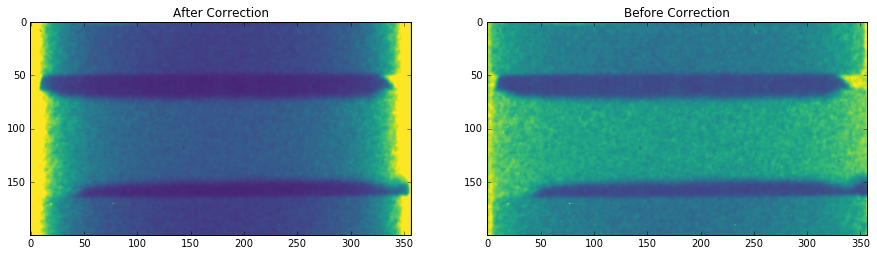

In [91]:
def plot_images(image_index, image_size):
    
    fig = plt.figure(figsize=(image_size, image_size))
    ax_img = plt.subplot(121)
    ax_img.imshow(all_corrected_images[image_index], cmap='viridis', vmin=0, vmax=1)
    ax_img.set_title("After Correction")
    
    ax_img = plt.subplot(122)
    ax_img.imshow(truncated_image[image_index], cmap='viridis', vmin=0, vmax=1)
    ax_img.set_title("Before Correction")

result = interact(plot_images,
                      image_index = widgets.IntSlider(min=0, 
                                                    max=len(data_array)-1,
                                                    step=1,
                                                    value=0,
                                                    description='Image Index'),
                      image_size = widgets.IntSlider(min=5,
                                                    max=20,
                                                    value=15))

# Prepare Images to Export Them

In [92]:
unrotated_images = []
for _image in all_corrected_images:
    _unrotated_image = np.rot90(_image, 3)
    unrotated_images.append(_unrotated_image)

In [93]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: We gonna save the new data set into tiff files.\
<br><br>Please select where you want to save those files....<b>Make sure the folder you select is empty!</b>\
<br><br>HELP: you are currently working with the following data set: ' +  os.path.basename(data_folder)  + '</span>'))

output_folder = config_handler.load_config(key='output_folder', group=ipts_group)
new_output_folder = gui_widgets.gui_dname(dir=output_folder,
                                   message='Select the Output Folder ...')
if new_output_folder:
    config_handler.save_config(key='output_folder', value=new_output_folder, group=ipts_group)
    
    short_list_of_data_files = [os.path.basename(_file) for _file in list_of_data_files]

    w = widgets.IntProgress()
    w.max = len(short_list_of_data_files)
    display(w)
    
    for _index, _short_file in enumerate(short_list_of_data_files):
        _full_file_name = os.path.join(new_output_folder, _short_file)
        _data = all_corrected_images[_index]
        file_handler.make_tiff(data=_data, filename=_full_file_name)
        w.value = _index+1
        
    print("TIFF files have been created in the folder: {}".format(new_output_folder))
    

TIFF files have been created in the folder: /Volumes/my_book_thunderbolt_duo/IPTS/IPTS_17099/cylindrical_geometry_corrected
